 # Segmenting and Clustering Neighborhoods in Toronto

## Introduction

In this assignment, I will explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. I will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format.

Once the data is in a structured format, I will explore and cluster the neighborhoods in the city of Toronto.

Firstly, let's download all the packages that we will require to complete the analysis
1. Folium
2. Seaborn


In [1]:
!pip install folium

In [2]:
!pip install beautifulsoup4

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

The neighborhood data for Toronto is available on [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

We will scrape this page using Beautifulsoup library and transform it into a dataset

In [10]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

resp = requests.get(url)
toronto_html = BeautifulSoup(resp.content)

In [11]:
soup = BeautifulSoup(str(toronto_html))

In [12]:
neighborhood_table = soup.find('table')

In [13]:
table_str = str(neighborhood_table.extract())

In [14]:
toronto_df = pd.read_html(table_str)[0]

In [15]:
toronto_df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## Pre-Processing

In [16]:
toronto_df.columns = ['PostalCode'] + list(toronto_df.columns)[1:]

In [17]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [18]:
toronto_df.shape

(287, 3)

I am removing the cells with a borough that is Not assigned

In [19]:
toronto_df.Borough.value_counts()

Not assigned        77
Etobicoke           44
North York          38
Scarborough         37
Downtown Toronto    37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Queen's Park         1
Mississauga          1
Name: Borough, dtype: int64

In [20]:
borough_na = toronto_df[toronto_df.Borough == 'Not assigned']
toronto_df.drop(borough_na.index, inplace=True)

In [21]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [22]:
toronto_df.shape

(210, 3)

Next, I will combine neighborhoods with the same postal code into one row

In [23]:
toronto_df = toronto_df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).to_frame()

In [24]:
toronto_df.reset_index(inplace=True)
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Let's check whether all Neighorhoods are valid

In [25]:
toronto_df[toronto_df.Neighborhood == "Not assigned"]

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Not assigned


If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [26]:
toronto_df.loc[85, 'Neighborhood'] = toronto_df.loc[85, 'Borough']
toronto_df[toronto_df.Neighborhood == "Not assigned"]

,PostalCode,Borough,Neighborhood


Nice! The empty dataframe indicates there are no neighborhoods in the dataset which have a borough name but no neighborhood name.

Following is the cleaned and processed dataframe

In [27]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [28]:
toronto_df.shape

(103, 3)

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In [32]:
geo_url = "https://cocl.us/Geospatial_data"

geocode_df = pd.read_csv(geo_url)
geocode_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geocode_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [33]:
toronto_df = pd.merge(toronto_df, geocode_df, on='PostalCode')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Explore Toronto dataset

In [34]:
toronto_latlong = [43.653225, -79.383186]

In [66]:
# create map of Manhattan using latitude and longitude values
toronto_map = folium.Map(location=toronto_latlong, zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#2E7D32',
        fill=True,
        fill_color='#FFEB3B',
        fill_opacity=0.75,
        parse_html=False).add_to(toronto_map)  

In [523]:
HTML(toronto_map._repr_html_())

### Foursqaure API

I've stored my foursqaure credentials in a file which I am reading  below

In [126]:
search_url = 'https://api.foursquare.com/v2/venues/search'

In [121]:
with open("creds.json", 'r') as f:
    creds = json.load(f)
CLIENT_ID = creds['id'] # your Foursquare ID
CLIENT_SECRET = creds['secret'] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + "*****")
print('CLIENT_SECRET:' + "*****")

Your credentails:
CLIENT_ID: *****
CLIENT_SECRET:*****


##### Let's explore one of the boroughs in our dataframe.

In [122]:
toronto_df.loc[0, 'Borough']

'Scarborough'

In [123]:
print('Latitude and longitude values of {} are {}, {}.'.format(toronto_df.loc[0, 'Borough'], 
                                                               toronto_df.loc[0, 'Latitude'], 
                                                               toronto_df.loc[0, 'Longitude']))

Latitude and longitude values of Scarborough are 43.806686299999996, -79.19435340000001.


##### Now, let's explore the Foursquare API using Scarborough

In [102]:
params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v=VERSION,
  ll=f"{toronto_df.loc[0, 'Latitude']}, {toronto_df.loc[0, 'Longitude']}",
  radius=500,
  limit=100
)

In [106]:
resp = requests.get(url=search_url, params=params)
data = resp.json()

Let's see how one venue data looks like....

In [110]:
data['response']['venues'][0]

{'id': '59dc417d08f521354fd3d5da',
 'name': 'Kaycan - SCARBOROUGH',
 'location': {'address': '70 Venture Drive,',
  'lat': 43.8067676622576,
  'lng': -79.19787526130676,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.8067676622576,
    'lng': -79.19787526130676}],
  'distance': 283,
  'postalCode': 'M1B 3L6',
  'cc': 'CA',
  'city': 'Scarborough',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['70 Venture Drive,',
   'Scarborough ON M1B 3L6',
   'Canada']},
 'categories': [{'id': '4bf58dd8d48988d130941735',
   'name': 'Building',
   'pluralName': 'Buildings',
   'shortName': 'Building',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1577713452',
 'hasPerk': False}

<br>
Now, let's write a function to extract important data from venue object. We can reuse the function for other boroughs as well intead of repeating the same code again and again.

In [149]:
def get_venues(neighborhood, lat, long, limit=100, radius=250):
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll=f"{lat}, {long}",
        radius=radius,
        limit=limit
    )
    venues = []
    data = requests.get(url=search_url, params=params).json()
    for v in data['response']['venues']:
        venues.append([neighborhood, lat, long, v['name'], v['location']['lat'], v['location']['lng'], 
                       ', '.join(x['name'] for x in v['categories'])])
    return venues

In [150]:
nbr_venues_df = pd.DataFrame()
columns=['Neighborhood', 'NeighborhoodLat', 'NeighborhoodLong', 'VenueName', 'VenueLat', 'VenueLong', 'VenueCategory']

In [151]:
for name, lat, long in zip(toronto_df.Neighborhood, toronto_df.Latitude, toronto_df.Longitude):
    nbr_venues_df = nbr_venues_df.append(get_venues(name, lat, long))

In [152]:
nbr_venues_df.columns = columns

In [153]:
nbr_venues_df.head()

,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Rouge, Malvern",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
1,"Rouge, Malvern",43.806686,-79.194353,Allied Technical Services,43.807999,-79.198802,Office
2,"Rouge, Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
3,"Rouge, Malvern",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
4,"Rouge, Malvern",43.806686,-79.194353,FASTSIGNS,43.807882,-79.201968,Business Service


In [154]:
nbr_venues_df.shape

(9875, 7)

<br>
Since we have limited number of request quota on Foursquare free tier, we will save the dataframe to a csv file, so that we can continue from here at a later point in time, if we need to close the notebook.

In [155]:
nbr_venues_df.to_csv('toronto_boroughs_and_venues.csv')

## Analyse Venue Data

Let's check the count of venue categories are in our dataset

In [478]:
nbr_venues_df = pd.read_csv('toronto_boroughs_and_venues.csv')
nbr_venues_df.drop(['Unnamed: 0'], axis=1, inplace=True)
nbr_venues_df.head()


,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Rouge, Malvern",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
1,"Rouge, Malvern",43.806686,-79.194353,Allied Technical Services,43.807999,-79.198802,Office
2,"Rouge, Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
3,"Rouge, Malvern",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
4,"Rouge, Malvern",43.806686,-79.194353,FASTSIGNS,43.807882,-79.201968,Business Service


We will remove rows with Empty VenueCategory

In [479]:
nbr_venues_df.VenueCategory.replace('', np.nan, inplace=True)
nbr_venues_df.dropna(inplace=True)
nbr_venues_df.shape

(8798, 7)

<br>
Let's check the frequency of each Venue Category

In [480]:
nbr_venues_df.VenueCategory.value_counts()

Office                                      560
Building                                    280
Residential Building (Apartment / Condo)    273
Salon / Barbershop                          193
Doctor's Office                             166
                                           ... 
Lighting Store                                1
Theme Restaurant                              1
Stationery Store                              1
Hindu Temple                                  1
German Restaurant                             1
Name: VenueCategory, Length: 499, dtype: int64

<br>Let's drop the venue categories which are not common, since they may add too much noise to our data

In [481]:
# Dropping rows i.e categories which are mentioned less than 15 times in the dataset
common_categories = nbr_venues_df.VenueCategory.unique()[nbr_venues_df.VenueCategory.value_counts()>15]

In [482]:
nbr_venues_df = nbr_venues_df[nbr_venues_df.VenueCategory.isin(common_categories)]
nbr_venues_df.shape

(6420, 7)

Now we will analyze how many venues of our interest are present in each neighbour hood

In [483]:
from IPython.core.display import HTML

display(HTML(nbr_venues_df.groupby('Neighborhood').count().to_html()))

,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
Neighborhood,,,,,,
"Adelaide, King, Richmond",59,59,59,59,59,59
Agincourt,70,70,70,70,70,70
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",55,55,55,55,55,55
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",76,76,76,76,76,76
"Alderwood, Long Branch",67,67,67,67,67,67
"Bathurst Manor, Downsview North, Wilson Heights",72,72,72,72,72,72
Bayview Village,69,69,69,69,69,69
"Bedford Park, Lawrence Manor East",56,56,56,56,56,56
Berczy Park,58,58,58,58,58,58


The least number of venues is:

In [484]:
nbr_venues_df.groupby('Neighborhood').count().VenueCategory.min()

12

So, for clustering, we will consider <b>Top 10</b> venue categories in each neighborhood as features.

We will do one-hot encoding of the VenueCategory column to convert them to features

In [485]:
# add neighborhood column back to dataframe
category_onehot = pd.get_dummies(nbr_venues_df.VenueCategory)
category_onehot['Neighborhood'] = nbr_venues_df.Neighborhood

# move neighborhood column to the first column
fixed_columns = [category_onehot.columns[-1]] + list(category_onehot.columns[:-1])
category_onehot = category_onehot[fixed_columns]

In [486]:
category_onehot.head()

,Neighborhood,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Tanning Salon,Tattoo Parlor,Tech Startup,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Zoo Exhibit
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [487]:
category_onehot.shape

(6420, 134)

<br>
Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [488]:
category_onehot = category_onehot.groupby('Neighborhood').mean().reset_index()
category_onehot

,Neighborhood,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Tanning Salon,Tattoo Parlor,Tech Startup,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Zoo Exhibit
0,"Adelaide, King, Richmond",0.0,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.016949,0.016949,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.014286,0.142857,...,0.0,0.000000,0.028571,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.000000,0.018182,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.018182,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.013158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,"Alderwood, Long Branch",0.0,0.000000,0.014925,0.014925,0.000000,0.014925,0.014925,0.000000,0.000000,...,0.0,0.000000,0.014925,0.014925,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Willowdale West,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.019231,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
98,Woburn,0.0,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.000000,0.011364,...,0.0,0.000000,0.000000,0.000000,0.011364,0.022727,0.0,0.011364,0.000000,0.0
99,"Woodbine Gardens, Parkview Hill",0.0,0.000000,0.000000,0.013699,0.000000,0.013699,0.000000,0.000000,0.027397,...,0.0,0.000000,0.013699,0.000000,0.000000,0.000000,0.0,0.000000,0.013699,0.0
100,Woodbine Heights,0.0,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.000000,0.032258,...,0.0,0.000000,0.016129,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


#### Let's print each neighborhood along with the top 5 most common venues

In [489]:
num_top_venues = 5

for nbrhood in category_onehot['Neighborhood']:
    print("---- "+nbrhood+" ----")
    temp = category_onehot[category_onehot['Neighborhood'] == nbrhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adelaide, King, Richmond ----
               venue  freq
0             Office  0.15
1               Café  0.07
2           Building  0.07
3        Coffee Shop  0.07
4  Indian Restaurant  0.03


---- Agincourt ----
             venue  freq
0  Automotive Shop  0.14
1           Office  0.11
2         Building  0.09
3   Hardware Store  0.06
4  Doctor's Office  0.04


---- Agincourt North, L'Amoreaux East, Milliken, Steeles East ----
                venue  freq
0     Doctor's Office  0.07
1  Chinese Restaurant  0.07
2              School  0.07
3            Building  0.05
4           BBQ Joint  0.05


---- Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown ----
                venue  freq
0  Salon / Barbershop  0.20
1    Spiritual Center  0.12
2         Pizza Place  0.11
3              Bakery  0.07
4      Medical Center  0.07


---- Alderwood, Long Branch ----
                venue  freq
0              Office  0.12
1         Gas

#### Let's put that into a *pandas* dataframe

In [490]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [491]:
indicators = ['st', 'nd', 'rd']
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nbr_venues_sorted_df = pd.DataFrame(columns=columns)
nbr_venues_sorted_df['Neighborhood'] = category_onehot['Neighborhood']

for ind in np.arange(category_onehot.shape[0]):
    nbr_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(category_onehot.iloc[ind, :], num_top_venues)

nbr_venues_sorted_df.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Office,Café,Building,Coffee Shop,Indian Restaurant,Financial or Legal Service,Hotel,Pool,Clothing Store,Japanese Restaurant
1,Agincourt,Automotive Shop,Office,Building,Hardware Store,Doctor's Office,Storage Facility,Auto Dealership,Chinese Restaurant,Rental Car Location,Tech Startup
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,School,Doctor's Office,Building,Medical Center,BBQ Joint,Bakery,Bus Line,Pizza Place,Pharmacy
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Salon / Barbershop,Spiritual Center,Pizza Place,Clothing Store,Church,Medical Center,Bakery,Hardware Store,Pharmacy,Grocery Store
4,"Alderwood, Long Branch",Office,Dentist's Office,Gas Station,Bank,Medical Center,Salon / Barbershop,Convenience Store,Factory,Breakfast Spot,Pizza Place


## Clustering Neighborhoods

In [492]:
from sklearn.cluster import KMeans

Let's assume we can cluster neighborhoods into three types based on venue categories. We will use **_'Elbow'_** method later to find the best number of clusters

In [493]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)

In [494]:
X = category_onehot.drop(['Neighborhood'], axis=1)
X.head()

,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,...,Tanning Salon,Tattoo Parlor,Tech Startup,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Zoo Exhibit
0,0.0,0.016949,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.016949,...,0.0,0.0,0.016949,0.016949,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,0.014286,0.142857,0.000000,...,0.0,0.0,0.028571,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.018182,0.036364,0.0,0.000000,0.000000,0.000000,0.000000,0.054545,...,0.0,0.0,0.018182,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.013158,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.014925,0.014925,0.0,0.014925,0.014925,0.000000,0.000000,0.014925,...,0.0,0.0,0.014925,0.014925,0.0,0.0,0.0,0.0,0.0,0.0


In [495]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [496]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [497]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

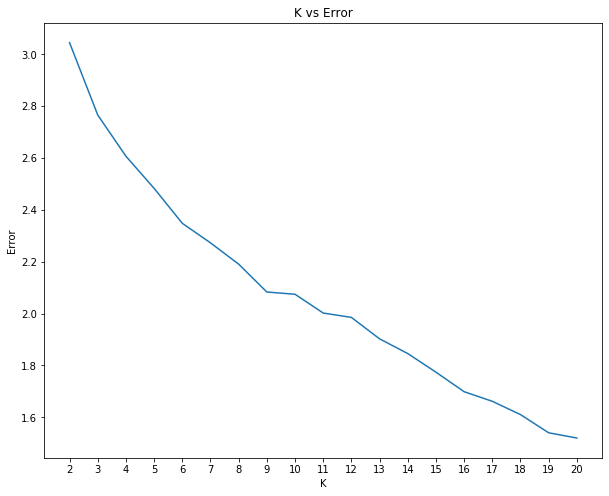

In [498]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

From the above visualization, we can say that the speed at which error reduces falls after K=9

In [499]:
# train final model with k=9
kmeans = KMeans(n_clusters=9)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [500]:
kmeans.labels_[:10]

array([0, 0, 3, 6, 0, 3, 3, 4, 2, 6], dtype=int32)

##### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [501]:
# add clustering labels
nbr_venues_sorted_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [510]:
toronto_nbr_df = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_nbr_df = toronto_nbr_df.join(nbr_venues_sorted_df.set_index('Neighborhood'), on='Neighborhood')

toronto_nbr_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,Office,Automotive Shop,Factory,Salon / Barbershop,Coffee Shop,Medical Center,Fast Food Restaurant,Doctor's Office,Building,Dentist's Office
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,6,Automotive Shop,Office,Medical Center,Salon / Barbershop,General Entertainment,Miscellaneous Shop,Gas Station,Nail Salon,Chinese Restaurant,Church
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,6,Residential Building (Apartment / Condo),Electronics Store,Church,Restaurant,Salon / Barbershop,School,Bus Line,Pizza Place,Bus Stop,Bank
3,M1G,Scarborough,Woburn,43.770992,-79.216917,4,Cosmetics Shop,Pharmacy,Residential Building (Apartment / Condo),Building,Convenience Store,Bus Stop,Salon / Barbershop,School,South Indian Restaurant,Coffee Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Doctor's Office,Building,Medical Center,Bakery,Automotive Shop,Residential Building (Apartment / Condo),Caribbean Restaurant,Office,Burger Joint,Pharmacy


##### Finally, let's visualize the resulting clusters

In [524]:
# create map
map_clusters = folium.Map(location=toronto_latlong, zoom_start=11)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_nbr_df['Latitude'], toronto_nbr_df['Longitude'], toronto_nbr_df['Neighborhood'], toronto_nbr_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [525]:
HTML(map_clusters._repr_html_())

## Examining Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

### Cluster 0

In [514]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 0, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge, Malvern",0,Office,Automotive Shop,Factory,Salon / Barbershop,Coffee Shop,Medical Center,Fast Food Restaurant,Doctor's Office,Building,Dentist's Office
12,Agincourt,0,Automotive Shop,Office,Building,Hardware Store,Doctor's Office,Storage Facility,Auto Dealership,Chinese Restaurant,Rental Car Location,Tech Startup
29,"Northwood Park, York University",0,Office,Building,Medical Center,Automotive Shop,Salon / Barbershop,Pharmacy,Doctor's Office,Gas Station,Caribbean Restaurant,Spa
43,Studio District,0,Building,Office,Coffee Shop,Nail Salon,Pharmacy,Automotive Shop,Café,Spa,Bakery,Restaurant
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0,Office,Residential Building (Apartment / Condo),Doctor's Office,Building,Medical Center,Dentist's Office,Café,Spiritual Center,Coffee Shop,Tech Startup
51,"Cabbagetown, St. James Town",0,Office,Café,Coffee Shop,Pizza Place,Pharmacy,Restaurant,Flower Shop,Tech Startup,Indian Restaurant,Laundry Service
57,Central Bay Street,0,Medical Center,Office,Coffee Shop,Pharmacy,Café,Fast Food Restaurant,Japanese Restaurant,Building,Pizza Place,Juice Bar
58,"Adelaide, King, Richmond",0,Office,Café,Building,Coffee Shop,Indian Restaurant,Financial or Legal Service,Hotel,Pool,Clothing Store,Japanese Restaurant
70,"First Canadian Place, Underground city",0,Office,Coffee Shop,Dentist's Office,Bakery,Health & Beauty Service,Building,Bank,Japanese Restaurant,Salon / Barbershop,Restaurant
71,"Lawrence Heights, Lawrence Manor",0,Clothing Store,Office,Design Studio,Miscellaneous Shop,Factory,Building,Automotive Shop,Bridal Shop,Cosmetics Shop,Skating Rink


### Cluster 1

In [515]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 1, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Silver Hills, York Mills",1,Park,Residential Building (Apartment / Condo),High School,Church,Pool,School,Convenience Store,Building,Library,Middle Eastern Restaurant
23,York Mills West,1,Residential Building (Apartment / Condo),Office,Gym,Church,Building,Medical Center,Park,School,Bus Line,Laundry Service
24,Willowdale West,1,Residential Building (Apartment / Condo),Park,Medical Center,Bank,Dentist's Office,Pizza Place,Financial or Legal Service,Spa,Doctor's Office,Pool
31,Downsview West,1,Residential Building (Apartment / Condo),Park,Elementary School,Bank,Salon / Barbershop,Building,Doctor's Office,Grocery Store,Pool,School
34,Victoria Village,1,Residential Building (Apartment / Condo),Office,Building,Park,Automotive Shop,Grocery Store,Convenience Store,School,Playground,Bank
45,Davisville North,1,Residential Building (Apartment / Condo),Office,Gym,Building,Dentist's Office,Playground,Medical Center,Hotel,Breakfast Spot,Optical Shop
50,Rosedale,1,Residential Building (Apartment / Condo),Office,Building,Park,Trail,Bank,General Travel,Salon / Barbershop,Bridge,Coffee Shop
52,Church and Wellesley,1,Residential Building (Apartment / Condo),Office,Building,Doctor's Office,Spa,Bank,Hotel,Gym / Fitness Center,Gym,Thrift / Vintage Store
59,"Harbourfront East, Toronto Islands, Union Station",1,Residential Building (Apartment / Condo),Office,Building,Coffee Shop,Doctor's Office,Fried Chicken Joint,Bank,Indian Restaurant,Electronics Store,Rental Car Location
65,"The Annex, North Midtown, Yorkville",1,Residential Building (Apartment / Condo),Office,Building,Gym,Coffee Shop,Laundry Service,Medical Center,Miscellaneous Shop,Japanese Restaurant,Café


### Cluster 2

In [516]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 2, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Don Mills North,2,Office,Building,Medical Center,School,Tech Startup,Doctor's Office,Veterinarian,Church,College Academic Building,College Lab
27,"Flemingdon Park, Don Mills South",2,Office,Building,General College & University,Doctor's Office,Restaurant,Coworking Space,Café,Asian Restaurant,Coffee Shop,Automotive Shop
53,Harbourfront,2,Office,Automotive Shop,Auto Dealership,Rental Car Location,Coffee Shop,Building,Park,Hardware Store,Design Studio,Assisted Living
55,St. James Town,2,Office,Residential Building (Apartment / Condo),Building,Event Space,Tech Startup,Coffee Shop,Design Studio,Laundry Service,Church,Clothing Store
56,Berczy Park,2,Office,Building,Tech Startup,Residential Building (Apartment / Condo),Breakfast Spot,Bar,Laundry Service,Hotel,Gym,Rental Car Location
60,"Design Exchange, Toronto Dominion Centre",2,Office,Restaurant,Coffee Shop,Park,Building,Cosmetics Shop,Sandwich Place,Tech Startup,Pharmacy,Event Space
61,"Commerce Court, Victoria Hotel",2,Office,Financial or Legal Service,Salon / Barbershop,Bank,Coffee Shop,Building,Restaurant,Bakery,Dentist's Office,Pharmacy
69,Stn A PO Boxes 25 The Esplanade,2,Office,Building,Residential Building (Apartment / Condo),Tech Startup,Bar,Hotel,Gym,Gym / Fitness Center,Event Space,Professional & Other Places
78,"Brockton, Exhibition Place, Parkdale Village",2,Office,Residential Building (Apartment / Condo),Tech Startup,Coworking Space,Building,Convenience Store,Coffee Shop,Spa,Dentist's Office,Fast Food Restaurant
86,Canada Post Gateway Processing Centre,2,Office,Building,Middle Eastern Restaurant,Chinese Restaurant,Gym,Hotel,Convenience Store,Automotive Shop,Breakfast Spot,Pizza Place


### Cluster 3

In [517]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 3, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Cedarbrae,3,Doctor's Office,Building,Medical Center,Bakery,Automotive Shop,Residential Building (Apartment / Condo),Caribbean Restaurant,Office,Burger Joint,Pharmacy
6,"East Birchmount Park, Ionview, Kennedy Park",3,Office,Dentist's Office,Church,Grocery Store,Pizza Place,Residential Building (Apartment / Condo),Pharmacy,Indian Restaurant,School,Bus Line
11,"Maryvale, Wexford",3,Middle Eastern Restaurant,Office,Grocery Store,Medical Center,Intersection,Coffee Shop,Church,Pizza Place,Auto Dealership,Pharmacy
13,"Clarks Corners, Sullivan, Tam O'Shanter",3,Doctor's Office,Chinese Restaurant,Gas Station,Automotive Shop,Bank,Dentist's Office,Church,Building,Pizza Place,Fried Chicken Joint
14,"Agincourt North, L'Amoreaux East, Milliken, St...",3,Chinese Restaurant,School,Doctor's Office,Building,Medical Center,BBQ Joint,Bakery,Bus Line,Pizza Place,Pharmacy
15,L'Amoreaux West,3,Doctor's Office,Bank,Chinese Restaurant,Office,Fast Food Restaurant,Dentist's Office,Clothing Store,Church,Residential Building (Apartment / Condo),Salon / Barbershop
19,Bayview Village,3,Church,Doctor's Office,Office,Salon / Barbershop,Bank,Residential Building (Apartment / Condo),Bus Line,Medical Center,Optical Shop,Café
28,"Bathurst Manor, Downsview North, Wilson Heights",3,Doctor's Office,Office,Medical Center,Residential Building (Apartment / Condo),Spa,Bank,Building,Salon / Barbershop,Convenience Store,Coffee Shop
32,Downsview Central,3,Government Building,Dentist's Office,Residential Building (Apartment / Condo),Office,Elementary School,Building,Pharmacy,Grocery Store,Library,School
33,Downsview Northwest,3,Caribbean Restaurant,Mobile Phone Shop,Residential Building (Apartment / Condo),Convenience Store,Church,Building,Pharmacy,Doctor's Office,Office,Bank


### Cluster 4

In [518]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 4, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Woburn,4,Cosmetics Shop,Pharmacy,Residential Building (Apartment / Condo),Building,Convenience Store,Bus Stop,Salon / Barbershop,School,South Indian Restaurant,Coffee Shop
16,Upper Rouge,4,Zoo Exhibit,Cosmetics Shop,Pizza Place,Park,Office,Playground,Bridge,Trail,Auto Dealership,General Entertainment
22,Willowdale South,4,Residential Building (Apartment / Condo),Office,Park,Salon / Barbershop,Coffee Shop,Japanese Restaurant,Bank,Building,Coworking Space,Cosmetics Shop
30,"CFB Toronto, Downsview East",4,Salon / Barbershop,Building,Coffee Shop,Office,Medical Center,Sandwich Place,Chinese Restaurant,Spa,Nail Salon,Park
37,The Beaches,4,School,Building,Laundry Service,Doctor's Office,Salon / Barbershop,Residential Building (Apartment / Condo),Playground,Flower Shop,Park,Breakfast Spot
41,"The Danforth West, Riverdale",4,Greek Restaurant,Spa,Office,Salon / Barbershop,Medical Center,Gym / Fitness Center,Intersection,Cosmetics Shop,Park,Miscellaneous Shop
42,"The Beaches West, India Bazaar",4,Park,Salon / Barbershop,Office,Medical Center,Pet Store,Convenience Store,Sandwich Place,Pizza Place,Building,Church
46,North Toronto West,4,Health & Beauty Service,Clothing Store,Cosmetics Shop,Spa,Coffee Shop,Dentist's Office,Arts & Crafts Store,Office,Church,Salon / Barbershop
47,Davisville,4,Coffee Shop,Café,Salon / Barbershop,Flower Shop,French Restaurant,Laundry Service,Building,Nail Salon,Thrift / Vintage Store,Pizza Place
48,"Moore Park, Summerhill East",4,Building,Office,Park,Residential Building (Apartment / Condo),Gym,Bank,Playground,Martial Arts Dojo,Gym / Fitness Center,Grocery Store


### Cluster 5

In [519]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 5, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Dorset Park, Scarborough Town Centre, Wexford ...",5,Automotive Shop,Office,Building,Factory,Auto Garage,Indian Restaurant,Bakery,Storage Facility,Pet Store,Electronics Store


### Cluster 6

In [520]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 6, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland Creek, Rouge Hill, Port Union",6,Automotive Shop,Office,Medical Center,Salon / Barbershop,General Entertainment,Miscellaneous Shop,Gas Station,Nail Salon,Chinese Restaurant,Church
2,"Guildwood, Morningside, West Hill",6,Residential Building (Apartment / Condo),Electronics Store,Church,Restaurant,Salon / Barbershop,School,Bus Line,Pizza Place,Bus Stop,Bank
5,Scarborough Village,6,Residential Building (Apartment / Condo),Building,Convenience Store,Automotive Shop,Pizza Place,Church,Gym / Fitness Center,Fast Food Restaurant,Gas Station,Salon / Barbershop
7,"Clairlea, Golden Mile, Oakridge",6,Bus Line,Park,Residential Building (Apartment / Condo),Automotive Shop,Convenience Store,Office,Bakery,Bus Station,Doctor's Office,Fast Food Restaurant
8,"Cliffcrest, Cliffside, Scarborough Village West",6,Pizza Place,Church,Office,Dentist's Office,Residential Building (Apartment / Condo),Spa,Salon / Barbershop,Laundry Service,Fast Food Restaurant,School
9,"Birch Cliff, Cliffside West",6,Church,Office,Park,Fast Food Restaurant,Laundry Service,Indian Restaurant,Thai Restaurant,Pizza Place,Government Building,Building
17,Hillcrest Village,6,Residential Building (Apartment / Condo),School,Convenience Store,Bank,Medical Center,Pizza Place,Mobile Phone Shop,Pharmacy,Chinese Restaurant,Pool
21,"Newtonbrook, Willowdale",6,Church,Bank,Korean Restaurant,Office,Medical Center,Park,Salon / Barbershop,Bus Line,Optical Shop,School
25,Parkwoods,6,Residential Building (Apartment / Condo),Bus Stop,Park,Office,Convenience Store,School,Elementary School,Spiritual Center,Pizza Place,Salon / Barbershop
35,"Woodbine Gardens, Parkview Hill",6,Office,Bus Stop,Building,Bank,Dentist's Office,Convenience Store,Fast Food Restaurant,Café,Flower Shop,Coffee Shop


### Cluster 7

In [521]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 7, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,"Ryerson, Garden District",7,College Lab,College Academic Building,Coffee Shop,General College & University,Salon / Barbershop,School,Church,Building,Café,Office
66,"Harbord, University of Toronto",7,College Academic Building,College Lab,Coffee Shop,General College & University,Church,College Gym,Building,Bank,Korean Restaurant,Chinese Restaurant


### Cluster 8

In [522]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 8, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",8,Clothing Store,Doctor's Office,Electronics Store,Jewelry Store,Optical Shop,Cosmetics Shop,Convenience Store,Restaurant,Medical Center,Bank
